**Objective :**<br>

The primary goal of this project is to develop a predictive model that identifies patients who are likely to miss their scheduled medical appointments (classified as "No-show") based on historical appointment data. The model aims to help healthcare providers proactively reduce no-show rates, improve resource allocation, and enhance patient care through timely reminders or follow-ups.

In [19]:
# importing the required libraries 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from imblearn.pipeline import Pipeline  
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix, roc_curve, auc, f1_score

In [2]:
# Reading the data from CSV into the pandas dataframe 
data = pd.read_csv('data.csv')
# Showing the first 5 rows of the dataframe 
data.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


In [3]:
# cleaning the data by removing the age which has value of -1 [noise]
data = data[data['Age']!=-1]

In [4]:
data.shape

(110526, 14)

The data has 1110526 rows ans 14 columns.

In [5]:
# Check if there are any null values in each of the columns
data.isna().any()

PatientId         False
AppointmentID     False
Gender            False
ScheduledDay      False
AppointmentDay    False
Age               False
Neighbourhood     False
Scholarship       False
Hipertension      False
Diabetes          False
Alcoholism        False
Handcap           False
SMS_received      False
No-show           False
dtype: bool

It can be observed that there are no null values in any of the columns.

In [6]:
# Checking the datatypes of each column.
data.dtypes

PatientId         float64
AppointmentID       int64
Gender             object
ScheduledDay       object
AppointmentDay     object
Age                 int64
Neighbourhood      object
Scholarship         int64
Hipertension        int64
Diabetes            int64
Alcoholism          int64
Handcap             int64
SMS_received        int64
No-show            object
dtype: object

* PatientId - Identification of a patient
* AppointmentID - Identification of each appointment
* Gender - Male or Female
* ScheduledDay - The day of the actuall appointment, when they have to visit the doctor.
* AppointmentDay - The day someone called or registered the appointment, this is before appointment of course.
* Age -How old is the patient.
* Neighbourhood - Where the appointment takes place.
* Scholarship - True of False.
* Hipertension - True or False
* Diabetes - True or False
* Alcoholism - True or False
* Handcap - True or False
* SMS_received - 1 or more messages sent to the patient.
* No-show - True or False.

**Research Questions:**<br>
1. What is the distribution of patient attendance (No vs Yes) for scheduled appointments?
2. Does receiving an SMS reminder influence whether a patient shows up for their appointment?
3. What is the distribution of appointments among diabetic vs non-diabetic patients?
4. Do patients with a history of alcoholism have higher no-show rates compared to those without?
5. Are hypertensive patients more or less likely to miss appointments compared to non-hypertensive patients?
6. What is the age distribution among patients who missed appointments compared to those who showed up?
7. Among patients who missed their appointments, does gender play a significant role in no-show behavior?

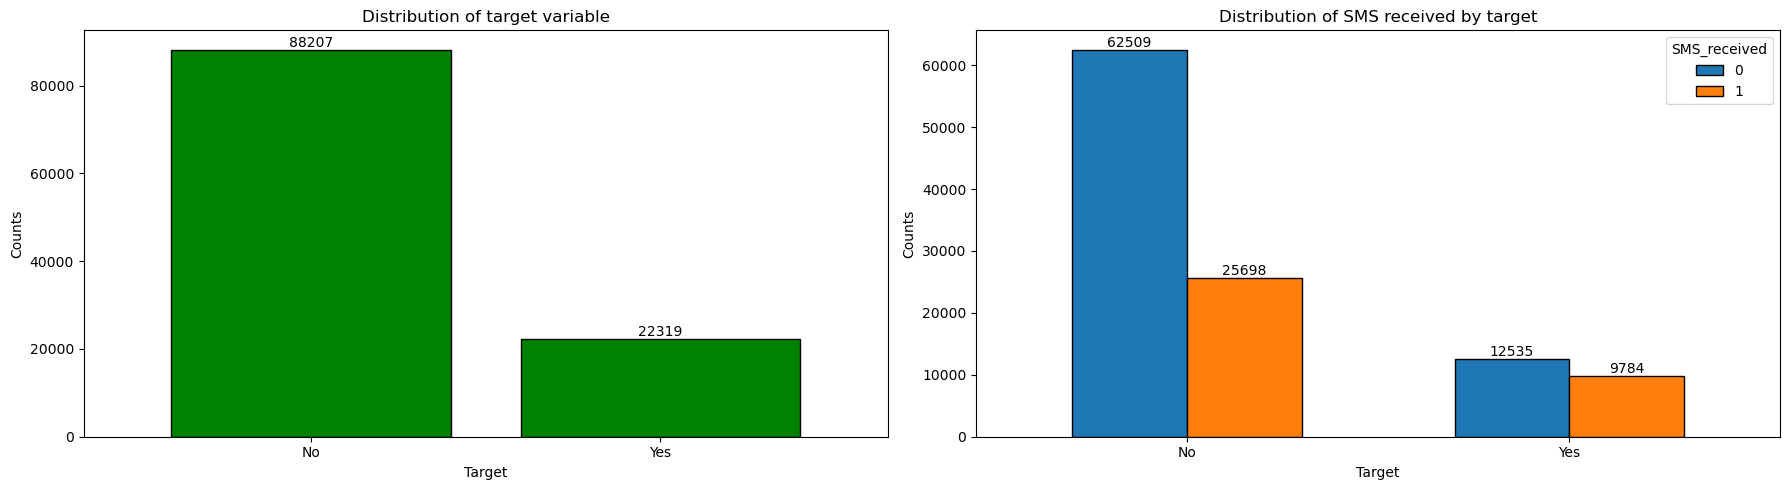

In [7]:
target_counts   = data['No-show'].value_counts().sort_values(ascending=False)
sms_counts      = data.groupby(['No-show', 'SMS_received']).size().unstack()

# Subplots: 1 row, 2 columns
fig, axes = plt.subplots(1, 2, figsize=(18, 5))

# Plot 1: Distribution of target variable
ax1 = axes[0]
target_counts.plot(kind='bar',
                   color='green',
                   edgecolor='black',
                   width=0.8,
                   ax=ax1)
for container in ax1.containers:
    ax1.bar_label(container)
ax1.set_xticklabels(target_counts.index, rotation=0)
ax1.set_xlabel('Target')
ax1.set_ylabel('Counts')
ax1.set_title('Distribution of target variable')

# Plot 2: Distribution of dropouts by marital status
ax2 = axes[1]
sms_counts.plot(kind='bar',
                     edgecolor='black',
                     width=0.6,
                     ax=ax2)
for container in ax2.containers:
    ax2.bar_label(container)
ax2.set_xticklabels(sms_counts.index, rotation=0)
ax2.set_xlabel('Target')
ax2.set_ylabel('Counts')
ax2.set_title('Distribution of SMS received by target')

plt.tight_layout()
plt.show()

**Observations:**<br>
* The dataset is highly imbalanced which is only ~20% of appointments are missed ("Yes"), while the remaining ~80% are attended ("No").
* Among the 22,319 patients who missed their appointments, 12,535 (≈56%) did not receive an SMS reminder and 9,784 (≈44%) did receive an SMS reminder.
* A majority of patients who missed their appointments did not receive an SMS.
* However, a significant portion (44%) still missed their appointments despite receiving a reminder, suggesting that SMS reminders alone are not fully effective in preventing no-shows.

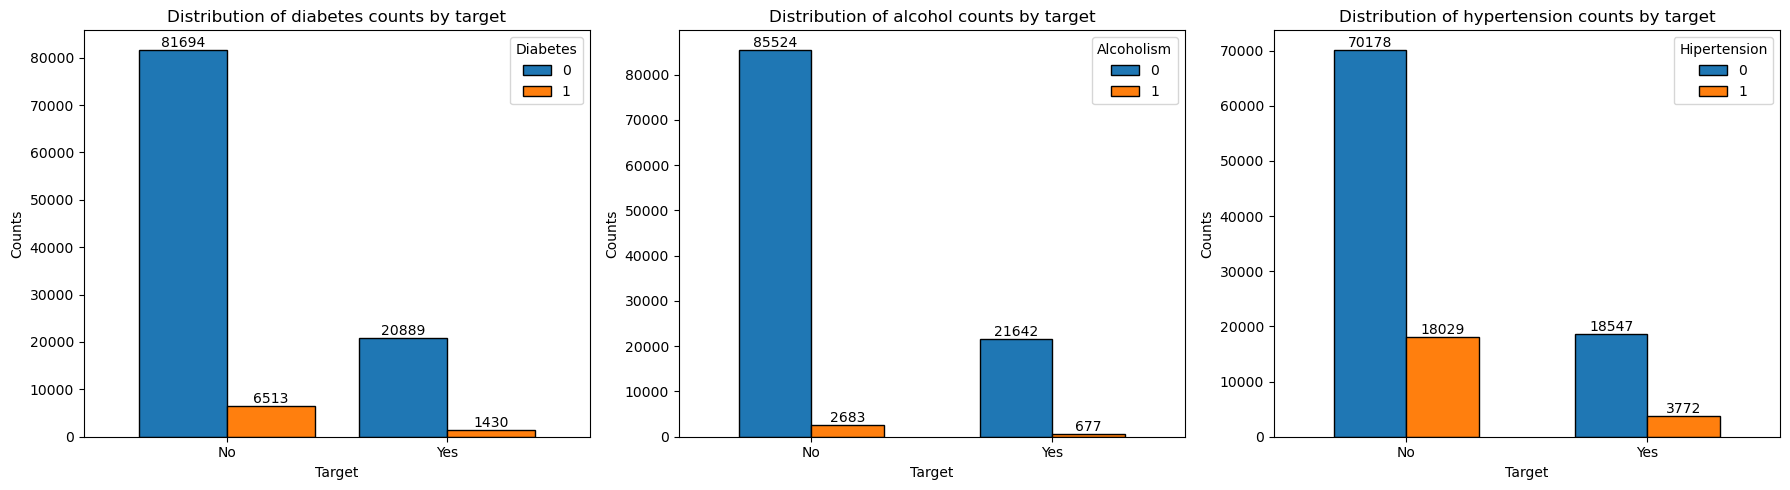

In [8]:
diabetes_counts     = data.groupby(['No-show', 'Diabetes']).size().unstack()
alcohol_counts      = data.groupby(['No-show', 'Alcoholism']).size().unstack()
hypertension_counts = data.groupby(['No-show', 'Hipertension']).size().unstack()

# Subplots: 1 row, 3 columns
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot 1: Distribution of target variable
ax1 = axes[0]
diabetes_counts.plot(kind='bar',
                   edgecolor='black',
                   width=0.8,
                   ax=ax1)
for container in ax1.containers:
    ax1.bar_label(container)
ax1.set_xticklabels(diabetes_counts.index, rotation=0)
ax1.set_xlabel('Target')
ax1.set_ylabel('Counts')
ax1.set_title('Distribution of diabetes counts by target')

# Plot 2: Distribution of dropouts by marital status
ax2 = axes[1]
alcohol_counts.plot(kind='bar',
                     edgecolor='black',
                     width=0.6,
                     ax=ax2)
for container in ax2.containers:
    ax2.bar_label(container)
ax2.set_xticklabels(alcohol_counts.index, rotation=0)
ax2.set_xlabel('Target')
ax2.set_ylabel('Counts')
ax2.set_title('Distribution of alcohol counts by target')

# Plot 2: Distribution of dropouts by marital status
ax3 = axes[2]
hypertension_counts.plot(kind='bar',
                     edgecolor='black',
                     width=0.6,
                     ax=ax3)
for container in ax3.containers:
    ax3.bar_label(container)
ax3.set_xticklabels(hypertension_counts.index, rotation=0)
ax3.set_xlabel('Target')
ax3.set_ylabel('Counts')
ax3.set_title('Distribution of hypertension counts by target')

plt.tight_layout()
plt.show()

**Observations:**<br>
* Out of 22,319 no-show patients, 20,889 (≈93.6%) did not have diabetes and 1,430 (≈6.4%) had diabetes. Diabetes appears to have no strong influence on missing appointments — the vast majority of no-show patients do not have diabetes.
* Out of 22,319 no-show patients, 21,642 (≈97%) had no history of alcoholism and 677 (≈3%) had alcoholism. Patients with alcoholism form a very small proportion of the no-show group, suggesting that alcoholism is not a key driver of appointment misses in this dataset.
* Out of 22,319 no-show patients, 18,547 (≈83%) were not hypertensive and 3,772 (≈17%) had hypertension. While still a minority, hypertensive patients make up a larger portion of the no-show group compared to diabetic or alcoholic patients. This suggests that hypertension might have a slightly stronger association with missed appointments.

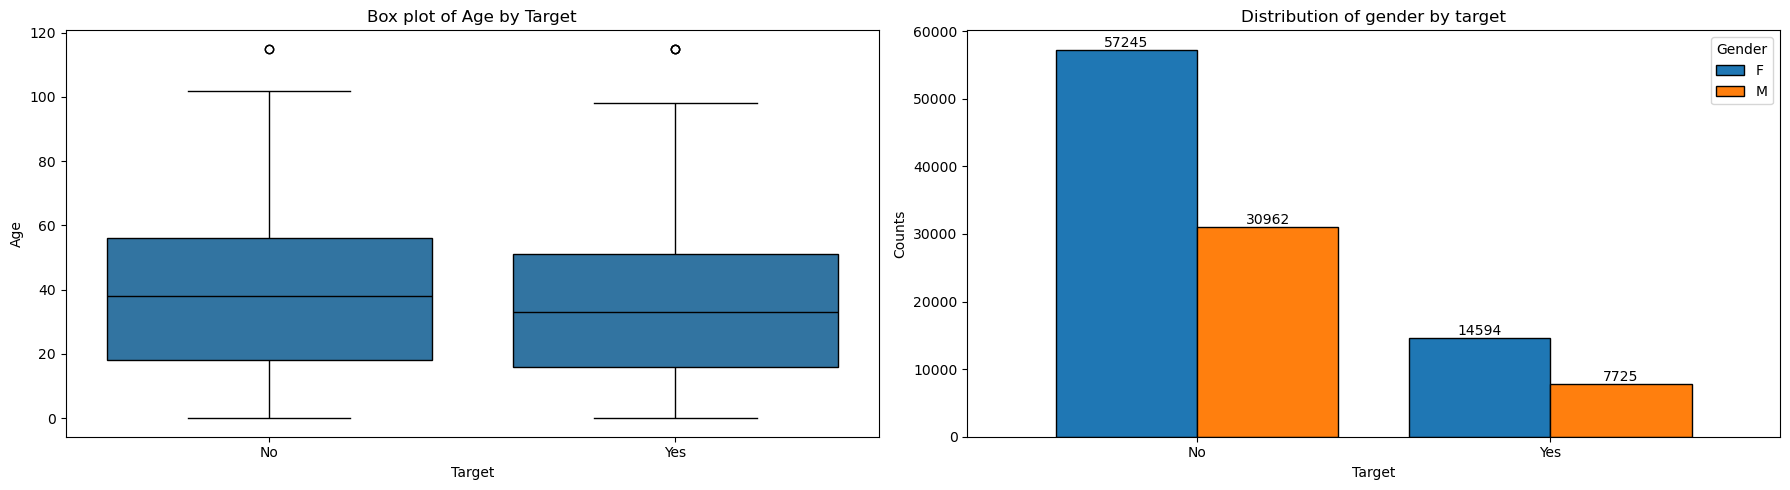

In [9]:
gender_counts = data.groupby(['No-show', 'Gender']).size().unstack()

# Subplots: 1 row, 3 columns
fig, axes = plt.subplots(1, 2, figsize=(18, 5))

# Plot 1: Distribution of target variable
ax1 = axes[0]
sns.boxplot(
    x='No-show',
    y='Age',
    data=data,
    ax = ax1,
    linecolor='black')

axes[0].set_xlabel('Target')
axes[0].set_ylabel('Age')
axes[0].set_title('Box plot of Age by Target')

# Plot 2: Distribution of target variable
ax2 = axes[1]
gender_counts.plot(kind='bar',
                   edgecolor='black',
                   width=0.8,
                   ax=ax2)
for container in ax2.containers:
    ax2.bar_label(container)
ax2.set_xticklabels(gender_counts.index, rotation=0)
ax2.set_xlabel('Target')
ax2.set_ylabel('Counts')
ax2.set_title('Distribution of gender by target')

plt.tight_layout()
plt.show()

**Observations:**
* The median age of no-show patients appears to be slightly lower than that of patients who showed up. Most no-show patients fall within the 20–50 year age range.
* Younger patients are slightly more likely to miss appointments than older ones. This suggests that age may influence no-show behavior, possibly due to differing lifestyle priorities or responsibilities.
* Among the 22,319 patients who missed their appointments, 14,594 (≈65%) were female and 7,725 (≈35%) were male. Female patients account for a higher proportion of missed appointments. 

In [10]:
data.drop(columns=['AppointmentID','PatientId']).corr(numeric_only=True)

,Age,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received
Age,1.000000,-0.092463,0.504586,0.292391,0.095810,0.078032,0.012633
Scholarship,-0.092463,1.000000,-0.019730,-0.024894,0.035022,-0.008587,0.001192
Hipertension,0.504586,-0.019730,1.000000,0.433085,0.087970,0.080083,-0.006270
Diabetes,0.292391,-0.024894,0.433085,1.000000,0.018473,0.057530,-0.014552
Alcoholism,0.095810,0.035022,0.087970,0.018473,1.000000,0.004647,-0.026149
Handcap,0.078032,-0.008587,0.080083,0.057530,0.004647,1.000000,-0.024162
SMS_received,0.012633,0.001192,-0.006270,-0.014552,-0.026149,-0.024162,1.000000


In [11]:
# Define features (X) and target (y)
X = data.drop(columns=['PatientId','AppointmentID','AppointmentDay','ScheduledDay','Neighbourhood','No-show'])
y = data['No-show']

In [585]:
rus = RandomUnderSampler(sampling_strategy = {'No': 8000,'Yes': 10000} , 
                         random_state=42)
x_rus, y_rus = rus.fit_resample(X, y)

In [586]:
y_rus.value_counts()

No-show
Yes    10000
No      8000
Name: count, dtype: int64

In [587]:
x_rus.head()

,Gender,Age,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received
82549,M,59,0,1,0,0,0,1
15963,F,54,0,0,0,0,0,0
101702,F,60,0,0,0,0,0,0
7908,M,3,0,0,0,0,0,0
49018,M,59,0,0,0,0,0,0


In [588]:
def binary_to_categorical(x):
    if x == 1:
        x = 'Y'
    else:
        x = 'N'
    return x    

In [589]:
x_rus['Scholarship'] = x_rus['Scholarship'].apply(lambda x: binary_to_categorical(x))
x_rus['Hipertension'] = x_rus['Hipertension'].apply(lambda x: binary_to_categorical(x))
x_rus['Diabetes'] = x_rus['Diabetes'].apply(lambda x: binary_to_categorical(x))
x_rus['Alcoholism'] = x_rus['Alcoholism'].apply(lambda x: binary_to_categorical(x))
x_rus['Handcap'] = x_rus['Handcap'].apply(lambda x: binary_to_categorical(x))
x_rus['SMS_received'] = x_rus['SMS_received'].apply(lambda x: binary_to_categorical(x))

In [590]:
#x_rus.head()

In [591]:
# Train-test split (e.g., 80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(x_rus, y_rus,
                                                    test_size=0.3,
                                                    random_state=42,
                                                    stratify=y_rus  # Ensures class proportions are preserved
                                                    )

In [592]:
label_encoder = LabelEncoder()

# Fit and transform the target variable
y_train_encoded = pd.DataFrame(label_encoder.fit_transform(y_train) ,columns = ['Target'])
y_test_encoded  = pd.DataFrame(label_encoder.transform(y_test) , columns = ['Target'])

In [593]:
{index: label for index, label in enumerate(label_encoder.classes_)}

{0: 'No', 1: 'Yes'}

In [594]:
(y_train_encoded.value_counts() / len(y_train_encoded))*100

Target
1         55.555556
0         44.444444
Name: count, dtype: float64

In [595]:
(y_test_encoded.value_counts() / len(y_test_encoded))*100

Target
1         55.555556
0         44.444444
Name: count, dtype: float64

In [596]:
# Check split sizes
print("Train size:", X_train.shape)
print("Test size:", X_test.shape)

Train size: (12600, 8)
Test size: (5400, 8)


In [597]:
X_train.dtypes

Gender          object
Age              int64
Scholarship     object
Hipertension    object
Diabetes        object
Alcoholism      object
Handcap         object
SMS_received    object
dtype: object

In [598]:
# Categorical columns (object)
categorical_cols = X_train.select_dtypes(include=['object']).columns.tolist()
# Numerical columns (float64)
numerical_cols   = X_train.select_dtypes(include=['int64']).columns.tolist()

In [599]:
# Step 1: Define transformers
numeric_transformer = Pipeline(steps=[
                            ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
                            ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Step 2: Combine transformers using ColumnTransformer
preprocessor = ColumnTransformer(transformers=[
                        ('num', numeric_transformer, numerical_cols),
                        ('cat', categorical_transformer, categorical_cols)])

In [600]:
clf_pipeline_rf = Pipeline(steps=[
                             ('preprocessor', preprocessor),
                             ('classifier',   RandomForestClassifier())])

# Hyperparameter grid for RandomForest
param_distributions_rf = {
    'classifier__n_estimators': [10, 20, 30, 50, 100, 200, 500, 1000],
    'classifier__max_depth': [2, 5, 10, 15, 20, 50, 100]}

# RandomizedSearchCV setup
random_search_rf = RandomizedSearchCV(
                    clf_pipeline_rf,
                    param_distributions=param_distributions_rf,
                    n_iter=6,
                    cv=3,
                    scoring = 'f1',
                    verbose=3)

In [601]:
# Fit search
random_search_rf.fit(X_train, y_train_encoded.values.ravel())

Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV 1/3] END classifier__max_depth=15, classifier__n_estimators=30;, score=0.637 total time=   0.2s
[CV 2/3] END classifier__max_depth=15, classifier__n_estimators=30;, score=0.634 total time=   0.1s
[CV 3/3] END classifier__max_depth=15, classifier__n_estimators=30;, score=0.613 total time=   0.2s
[CV 1/3] END classifier__max_depth=100, classifier__n_estimators=500;, score=0.629 total time=   4.1s
[CV 2/3] END classifier__max_depth=100, classifier__n_estimators=500;, score=0.632 total time=   3.8s
[CV 3/3] END classifier__max_depth=100, classifier__n_estimators=500;, score=0.614 total time=   3.7s
[CV 1/3] END classifier__max_depth=15, classifier__n_estimators=1000;, score=0.635 total time=   6.8s
[CV 2/3] END classifier__max_depth=15, classifier__n_estimators=1000;, score=0.636 total time=   7.4s
[CV 3/3] END classifier__max_depth=15, classifier__n_estimators=1000;, score=0.622 total time=   6.9s
[CV 1/3] END classifier__max

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('scaler',
                                                                                                StandardScaler())]),
                                                                               ['Age']),
                                                                              ('cat',
                                                                               Pipeline(steps=[('onehot',
                                                                                                OneHotEncoder(handle_unknown='ignore'))]),
                                                                               ['Gender',
                                                                                'Scholarship',
                                                                                'Hipertension',
                                                                                'Diabetes',
                                                                                'Alcoholism',
                                                                                'Handcap',
                                                                                'SMS_received'])])),
                                             ('classifier',
                                              RandomForestClassifier())]),
                   n_iter=6,
                   param_distributions={'classifier__max_depth': [2, 5, 10, 15,
                                                                  20, 50, 100],
                                        'classifier__n_estimators': [10, 20, 30,
                                                                     50, 100,
                                                                     200, 500,
                                                                     1000]},
                   scoring='f1', verbose=3)

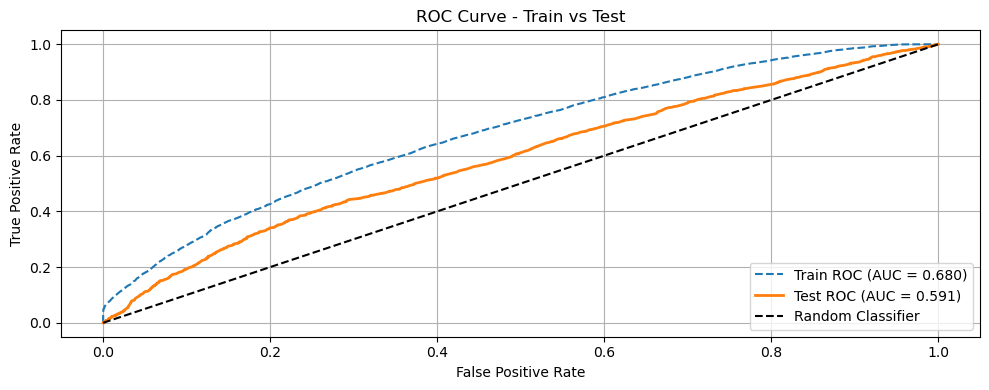

In [602]:
# Best estimator from the search
best_model = random_search_rf.best_estimator_

# Predict probabilities
y_train_proba = best_model.predict_proba(X_train)[:, 1]
y_test_proba  = best_model.predict_proba(X_test)[:, 1]

# Get ROC curve values
fpr_train, tpr_train, _ = roc_curve(y_train_encoded.values.ravel(), y_train_proba)
fpr_test, tpr_test, _   = roc_curve(y_test_encoded.values.ravel(), y_test_proba)

# Compute AUC
auc_train = auc(fpr_train, tpr_train)
auc_test  = auc(fpr_test, tpr_test)

# Plot ROC curve
plt.figure(figsize=(10, 4))
plt.plot(fpr_train, tpr_train, label=f'Train ROC (AUC = {auc_train:.3f})', linestyle='--')
plt.plot(fpr_test, tpr_test, label=f'Test ROC (AUC = {auc_test:.3f})', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Train vs Test')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

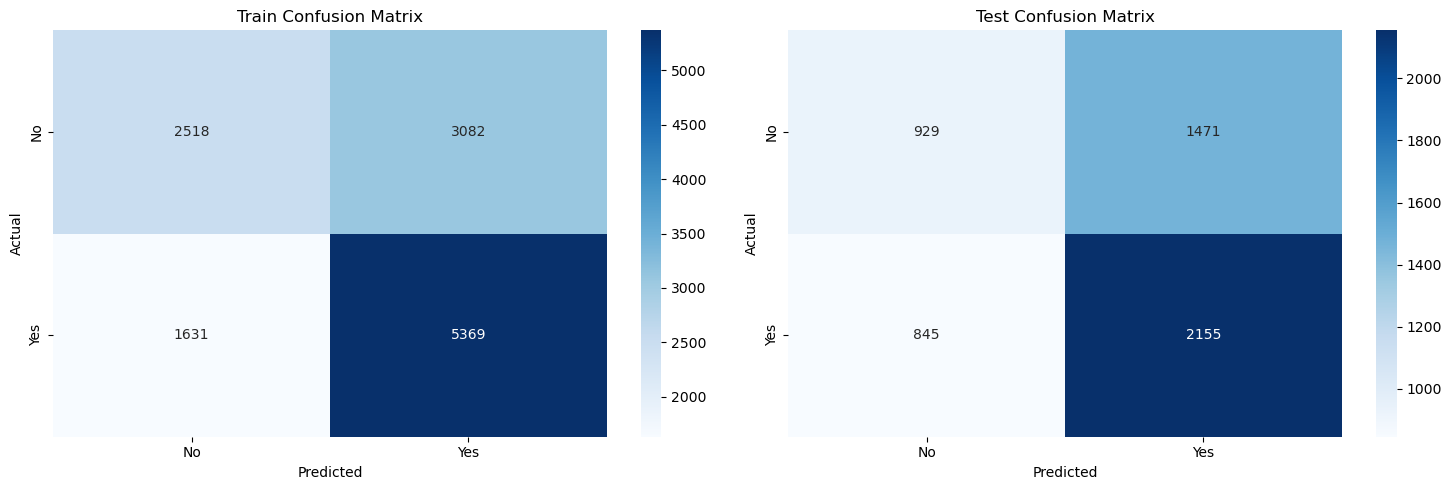

In [603]:
# Predict for train and test
y_train_pred_rf = random_search_rf.predict(X_train)
y_test_pred_rf  = random_search_rf.predict(X_test)

# Compute confusion matrices
labels = list(range(len(label_encoder.classes_)))
class_names = label_encoder.classes_

cm_train_rf = confusion_matrix(y_train_encoded, y_train_pred_rf, labels=labels)
cm_test_rf  = confusion_matrix(y_test_encoded, y_test_pred_rf, labels=labels)  

# Plot side-by-side heatmaps
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Train
sns.heatmap(cm_train_rf, xticklabels=class_names, yticklabels=class_names, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('Train Confusion Matrix')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

# Test
sns.heatmap(cm_test_rf, xticklabels=class_names, yticklabels=class_names, annot=True, fmt='d', cmap='Blues', ax=axes[1])
axes[1].set_title('Test Confusion Matrix')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')

plt.tight_layout()
plt.show()

In [607]:
# XGBoost pipeline

clf_pipeline_xgb = Pipeline(steps=[
                    ('preprocessor', preprocessor),
                    ('classifier',   XGBClassifier())])

# Hyperparameter grid for XGBoost
param_distributions_xgb = {
    'classifier__n_estimators': [10, 20, 50, 100, 150],
    'classifier__max_depth': [3, 5, 7, 10, 15, 20]}

# RandomizedSearchCV setup
random_search_xgb = RandomizedSearchCV(
                     clf_pipeline_xgb,
                     param_distributions=param_distributions_xgb,
                     n_iter=6,
                     cv=3,
                     verbose=3,
                     scoring='f1')

In [608]:
# Fit the model
random_search_xgb.fit(X_train, y_train_encoded)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV 1/3] END classifier__max_depth=20, classifier__n_estimators=50;, score=0.631 total time=   0.2s
[CV 2/3] END classifier__max_depth=20, classifier__n_estimators=50;, score=0.629 total time=   0.2s
[CV 3/3] END classifier__max_depth=20, classifier__n_estimators=50;, score=0.608 total time=   0.2s
[CV 1/3] END classifier__max_depth=15, classifier__n_estimators=10;, score=0.635 total time=   0.0s
[CV 2/3] END classifier__max_depth=15, classifier__n_estimators=10;, score=0.637 total time=   0.0s
[CV 3/3] END classifier__max_depth=15, classifier__n_estimators=10;, score=0.617 total time=   0.0s
[CV 1/3] END classifier__max_depth=10, classifier__n_estimators=150;, score=0.632 total time=   0.1s
[CV 2/3] END classifier__max_depth=10, classifier__n_estimators=150;, score=0.636 total time=   0.1s
[CV 3/3] END classifier__max_depth=10, classifier__n_estimators=150;, score=0.616 total time=   0.2s
[CV 1/3] END classifier__max_depth=15

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('scaler',
                                                                                                StandardScaler())]),
                                                                               ['Age']),
                                                                              ('cat',
                                                                               Pipeline(steps=[('onehot',
                                                                                                OneHotEncoder(handle_unknown='ignore'))]),
                                                                               ['Gender',
                                                                                'Scholarship',
                                                                                'Hipertension',
                                                                                'Diabetes',
                                                                                'Alcoholism',
                                                                                'Handcap',
                                                                                'SMS_received'])])),
                                             ('classifier',
                                              XGBClass...
                                                            max_delta_step=None,
                                                            max_depth=None,
                                                            max_leaves=None,
                                                            min_child_weight=None,
                                                            missing=nan,
                                                            monotone_constraints=None,
                                                            multi_strategy=None,
                                                            n_estimators=None,
                                                            n_jobs=None,
                                                            num_parallel_tree=None,
                                                            random_state=None, ...))]),
                   n_iter=6,
                   param_distributions={'classifier__max_depth': [3, 5, 7, 10,
                                                                  15, 20],
                                        'classifier__n_estimators': [10, 20, 50,
                                                                     100,
                                                                     150]},
                   scoring='f1', verbose=3)

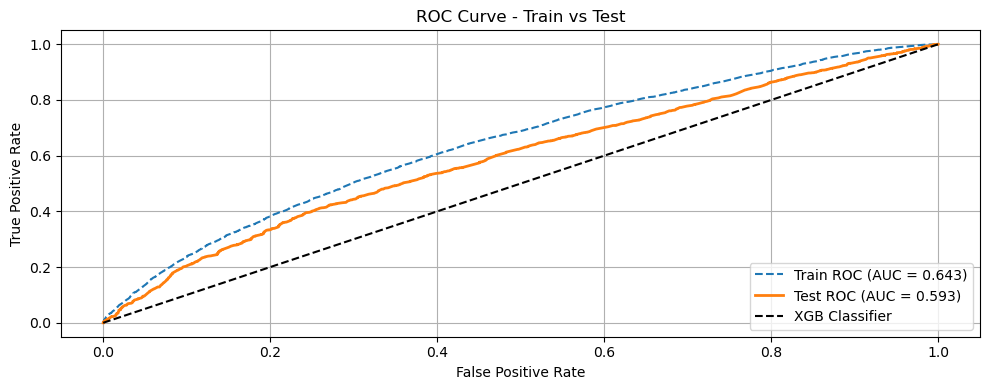

In [609]:
# Best estimator from the search
best_model = random_search_xgb.best_estimator_

# Predict probabilities
y_train_proba = best_model.predict_proba(X_train)[:, 1]
y_test_proba  = best_model.predict_proba(X_test)[:, 1]

# Get ROC curve values
fpr_train, tpr_train, _ = roc_curve(y_train_encoded.values.ravel(), y_train_proba)
fpr_test, tpr_test, _   = roc_curve(y_test_encoded.values.ravel(), y_test_proba)

# Compute AUC
auc_train = auc(fpr_train, tpr_train)
auc_test  = auc(fpr_test, tpr_test)

# Plot ROC curve
plt.figure(figsize=(10, 4))
plt.plot(fpr_train, tpr_train, label=f'Train ROC (AUC = {auc_train:.3f})', linestyle='--')
plt.plot(fpr_test, tpr_test, label=f'Test ROC (AUC = {auc_test:.3f})', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', label='XGB Classifier')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Train vs Test')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

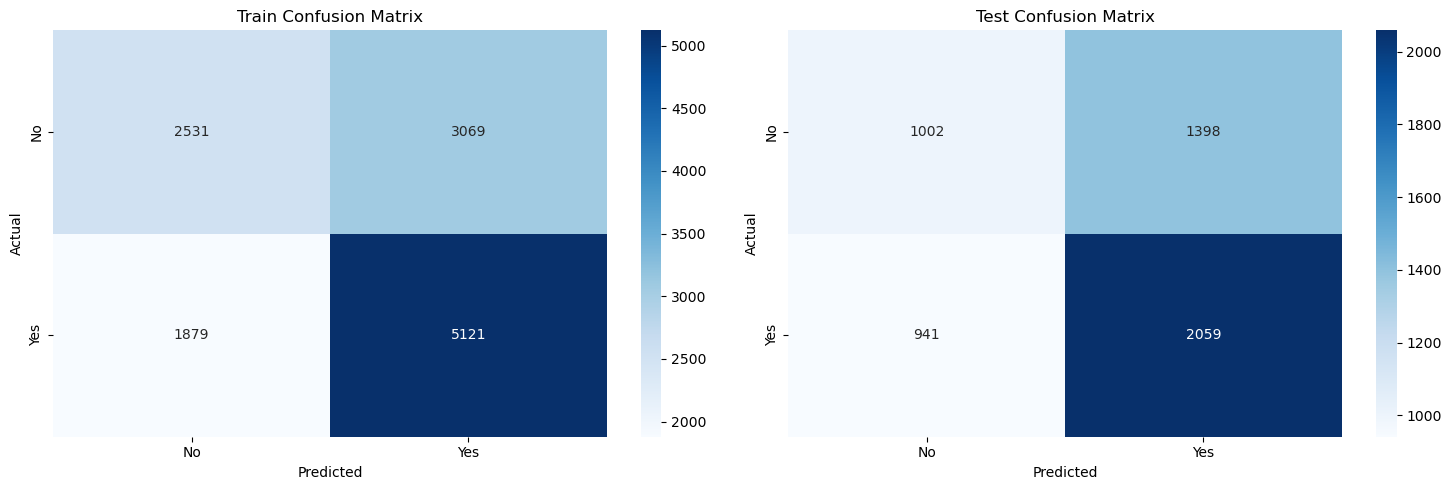

In [610]:
# Predict for train and test
y_train_pred_xgb = random_search_xgb.predict(X_train)
y_test_pred_xgb  = random_search_xgb.predict(X_test)

# Compute confusion matrices
labels = list(range(len(label_encoder.classes_)))
class_names = label_encoder.classes_

cm_train_xgb = confusion_matrix(y_train_encoded, y_train_pred_xgb, labels=labels)
cm_test_xgb  = confusion_matrix(y_test_encoded, y_test_pred_xgb, labels=labels)  

# Plot side-by-side heatmaps
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Train
sns.heatmap(cm_train_xgb, xticklabels=class_names, yticklabels=class_names, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('Train Confusion Matrix')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

# Test
sns.heatmap(cm_test_xgb, xticklabels=class_names, yticklabels=class_names, annot=True, fmt='d', cmap='Blues', ax=axes[1])
axes[1].set_title('Test Confusion Matrix')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')

plt.tight_layout()
plt.show()